## Summary: Human-in-the-Loop Approvals and Edits in LangGraph Workflows  
Overview  
This demo introduces human-in-the-loop (HITL) techniques for LangGraph workflows, allowing users to approve, reject, or edit the state before certain actions (like tool calls) proceed. This control mechanism is vital for building safe and supervised AI systems.

Key Steps Covered  
1. Basic Workflow Structure  
a. State Definition
The custom state includes:
question: str
answer: str
MessagesState is inherited for managing message history.

class State(MessagesState):
  question: str
  answer: str  
b. Nodes
Entry Point:
Receives the user question and builds system and human messages.
Agent Node:
Binds the web search tool to the LLM.
Invokes the LLM with the current messages.
Updates the answer field.
def entry_point(state):
  ...
def agent(state):
  ...  
c. Router
If the latest message contains tool_calls, the workflow proceeds to tools.
Otherwise, it terminates.
def router(state):
  last_message = state["messages"][-1]
  return "tools" if last_message.tool_calls else END

In [2]:
import os
from typing import Dict
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

In [3]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [4]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

2. Introducing Breakpoints  
During graph compilation, interrupt_before=["tools"] is specified.

This pauses the workflow execution before tools are called.

Workflow visualization:

start → entry_point → agent → [breakpoint] tools → agent → end

graph = workflow.compile(interrupt_before=["tools"], checkpointer=memory)
Initial example:

Question: "What's the capital of Brazil?"

Workflow pauses after agent identifies a web search is needed.

In [5]:
class State(MessagesState):
    question: str
    answer: str

In [6]:
llm_with_tools = llm.bind_tools([web_search])

In [7]:
def entry_point(state: State):
    question = state["question"]
    system_message = SystemMessage("You conduct web search to respond to user's questions")
    human_message = HumanMessage(question)
    messages = [system_message, human_message]
    return {"messages": messages}

In [8]:
def agent(state: State):
    messages = state["messages"]
    ai_message = llm_with_tools.invoke(messages)
    return {"messages": ai_message, "answer": ai_message.content}

In [9]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [ ]:
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([web_search]))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")
workflow.add_conditional_edges(
    source="agent",
    path=router,
    path_map=["tools", END]
)
workflow.add_edge("tools", "agent")

In [ ]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["tools"],
    checkpointer=memory
)

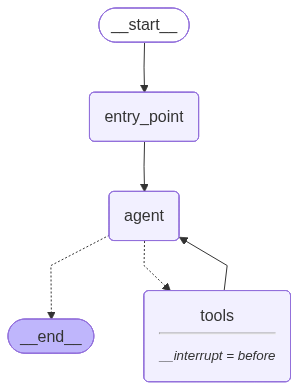

In [12]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [13]:
input_question = {"question": "what's the capital of Brazil?"}
config = {"configurable": {"thread_id": 1}}

In [14]:
for event in graph.stream(input=input_question, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_LpjIovTVNnmRXbu2GdDyWqfz)
 Call ID: call_LpjIovTVNnmRXbu2GdDyWqfz
  Args:
    question: capital of Brazil


In [15]:
state = graph.get_state(config=config)

In [16]:
state

StateSnapshot(values={'messages': [SystemMessage(content="You conduct web search to respond to user's questions", additional_kwargs={}, response_metadata={}, id='cb894ff8-d6a9-49e5-a0bb-961aa3735527'), HumanMessage(content="what's the capital of Brazil?", additional_kwargs={}, response_metadata={}, id='9b050c2e-c507-4fda-9227-20821a557326'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LpjIovTVNnmRXbu2GdDyWqfz', 'function': {'arguments': '{"question":"capital of Brazil"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 64, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CQbcNN9FAR0qyw0iQSb9VIbAFjbdF', '

In [17]:
state.next

('tools',)

In [18]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (call_LpjIovTVNnmRXbu2GdDyWqfz)
 Call ID: call_LpjIovTVNnmRXbu2GdDyWqfz
  Args:
    question: capital of Brazil
================================= Tool Message =================================
Name: web_search

{"query": "capital of Brazil", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Bras%C3%ADlia", "title": "Brasília - Wikipedia", "content": "Brasília is the capital city of Brazil and the Federal District. Located in the Brazilian highlands in the country's Central-West region, it was founded by", "score": 0.8752871, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/Capitals_of_Brazil", "title": "Capitals of Brazil - Wikipedia", "content": "Jump to content ## Contents * 1 History * Edit * Edit * Permanent link * Page information * Cite this page * Download QR code Print/export * Download as PDF ## Histor

## 3. Human Approval Flow  
a. Basic Approval  
A function human_in_the_loop_run streams the workflow.

After seeing the agent’s intent (e.g., to call a tool), the human is prompted:

YES: Continue execution.

NO: Abort workflow.


human_input = input("Do you approve the tool calling? (YES or NO): ")
Example:

Approving → Continues and retrieves the correct answer.

Rejecting → Prints "Workflow aborted by a human."

b. More Interactive Control (Human Revision)  
Workflow is modified to interrupt before the agent instead of tools.

If the user says NO to the initial question:

They are prompted to edit the question.

A system message ("Workflow edited by a human") and a new human message are inserted.


human_input = input("So what should be the question? ")
The graph state is updated with the revised input.

Execution then resumes from the updated state.

Example:

Original: "What’s the capital of Brazil?"

Edit to: "What’s the capital of Canada?"

Output: "The capital of Canada is Ottawa."

In [ ]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you approve the tool calling? (YES or NO): ")
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()

    else:
        SystemMessage("Workflow aborted by a human").pretty_print()

In [20]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=2,
)

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_zfjj7WsXrrvnfUMXgDTZhS1u)
 Call ID: call_zfjj7WsXrrvnfUMXgDTZhS1u
  Args:
    question: What is the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_zfjj7WsXrrvnfUMXgDTZhS1u)
 Call ID: call_zfjj7WsXrrvnfUMXgDTZhS1u
  Args:
    question: What is the capital of Brazil?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Brazil?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.facebook.com/ProjectNightfall/posts/whats-the-capital-city-of-brazil/1187126319451177/", "title": "What's the capital city of Brazil? - Facebook", "content": "What's the capital city of Brazi

In [ ]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Mexico?",
    thread_id=3,
)

## 4. Second Human Step After Tool Messages  
After a tool call, the human again can:

Review.

Continue execution.

Potentially enhance logic to approve post-tool actions.

In [ ]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["agent"],
    checkpointer=memory
)

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you want to proceed with this question? (YES or NO): ")

    if human_input.lower() == "no":
        human_input = input("So what should be the question? ")
        human_message = HumanMessage(content=human_input)
        system_message = SystemMessage("Workflow edited by a human")
        system_message.pretty_print()
        graph.update_state(
            config=config,
            values={
                "messages": [
                    system_message,
                    human_message,
                ]
            },
        )

        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()

    for event in graph.stream(input=None, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()


In [ ]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=4,
)

In [ ]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=5,
)

## 5. Key Concepts Highlighted  
Breakpoints allow controlled interruptions during workflows.

Human approvals ensure critical actions (like external API calls) can be supervised.

Human edits allow correction of user input before significant processing happens.

Thread IDs manage session persistence, enabling inspection and modification across sessions.

## 6. Conclusion  
Human-in-the-loop mechanisms enhance AI system transparency and safety.

LangGraph’s breakpoint and checkpoint features make integrating HITL workflows straightforward.

A next enhancement would be extending approval loops after tool messages, enabling full-cycle human supervision.